# Pegasos Quantum Support Vector Classifier

## Overview
In this tutorial, we will implement another SVM based algorithm that benefits from the quantum kernel method, namely `PegasosQSVC` from Qiskit Machine Learning.

## Introduction
Here, we are demonstrating another approach to classification that implements the Pegasos algorithm from the paper [Pegasos: Primal Estimated sub-GrAdient SOlver for SVM](https://home.ttic.edu/~nati/Publications/PegasosMPB.pdf) by Shalev-Shwartz et al. We introduce the implementation of the classification algorithm, `PegasosQSVC`, as an alternative to the `QSVC` available in Qiskit Machine Learning. For a refresher on QSVC, revisit ["Quantum Kernel Machine Learning"](./03_quantum_kernel.ipynb) tutorial. 

The `PegasosQSVC` algorithm is an alternative to the dual optimization from the `scikit-learn` package, benefits from the kernel trick, and yields a training complexity that is independent of the size of the training set. Thus, the `PegasosQSVC` is expected to train faster than QSVC for sufficiently large training sets.

The algorithm can be used as direct replacement of `QSVC` with some hyper-parameterization.

### 1. Preparing dataset

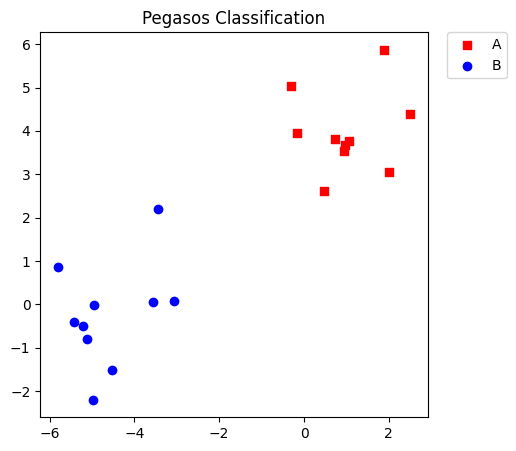

In [1]:
# Required imports
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt

# Generate dataset for binary classification
features, labels = make_blobs(n_samples=20, n_features=2, centers=2, random_state=3, shuffle=True)

# Plot the dataset
plt.figure(figsize=(5, 5))

# Class A or 0
plt.scatter(
    features[:, 0][labels == 0],  # x (index 0) coordinate of class A (label 0)
    features[:, 1][labels == 0],  # y (index 1) coordinate of class A (label 0)
    marker="s",
    facecolors="r",
    edgecolors="r",
    label="A",
)

# Class B or 1
plt.scatter(
    features[:, 0][labels == 1],  # x (index 0) coordinate of class B (label 1)
    features[:, 1][labels == 1],  # y (index 1) coordinate of class B (label 1)
    marker="o",
    facecolors="b",
    edgecolors="b",
    label="B",
)

plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.0)
plt.title("Pegasos Classification")
plt.show()

### 2. Data Pre-processing: Feature Scaling and Splitting of dataset (Train and Test)
We pre-process the data to ensure compatibility with the rotation encoding and split it into the training and testing datasets.

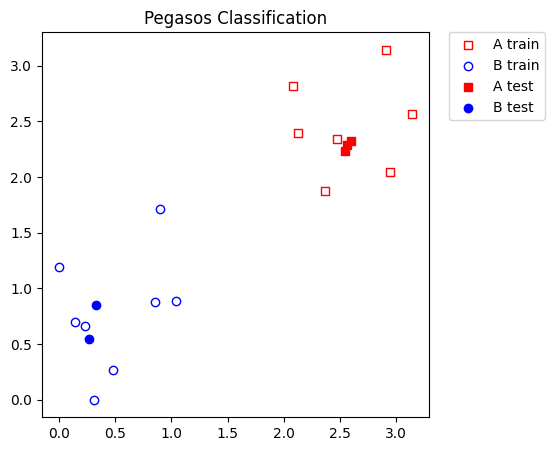

In [2]:
# Required imports
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Scale the features using MinMaxScaler
features = MinMaxScaler(feature_range=(0, np.pi)).fit_transform(features)

# Split the dataset into train and test
train_features, test_features, train_labels, test_labels = train_test_split(
    features, labels, train_size=15, shuffle=False
)

# Specify the plot settings
plt.figure(figsize=(5, 5))

# Reusable function to plot the train and test dataset
def plot_dataset(train_features, test_features, train_labels, test_labels):
    # Class: A train
    plt.scatter(
        # x (index 0) coordinate of class A (label 0) in training samples
        train_features[:, 0][train_labels == 0],
        # y (index 1) coordinate of class A (label 0) in training samples
        train_features[:, 1][train_labels == 0],
        marker="s",
        facecolors="w",
        edgecolors="r",
        label="A train",
    )

    # Class: B train
    plt.scatter(
        # x (index 0) coordinate of class B (label 1) in training samples
        train_features[:, 0][train_labels == 1],
        # y (index 1) coordinate of class B (label 1) in training samples
        train_features[:, 1][train_labels == 1],
        marker="o",
        facecolors="w",
        edgecolors="b",
        label="B train",
    )

    # Class: A test
    plt.scatter(
        # x (index 0) coordinate of class A (label 0) in testing samples
        test_features[:, 0][test_labels == 0],
        # y (index 1) coordinate of class A (label 0) in testing samples
        test_features[:, 1][test_labels == 0],
        marker="s",
        facecolors="r",
        edgecolors="r",
        label="A test",
    )

    # Class: B test
    plt.scatter(
        # x (index 0) coordinate of class B (label 1) in testing samples
        test_features[:, 0][test_labels == 1],
        # y (index 1) coordinate of class B (label 1) in testing samples
        test_features[:, 1][test_labels == 1],
        marker="o",
        facecolors="b",
        edgecolors="b",
        label="B test",
    )

    # Plot the classification
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.0)
    plt.title("Pegasos Classification")


plot_dataset(train_features, test_features, train_labels, test_labels)
plt.show()

### 3. Set Tuning Parameters of [PegasosQSVC](https://qiskit.org/documentation/machine-learning/stubs/qiskit_machine_learning.algorithms.PegasosQSVC.html)

#### Number of qubits
Start by setting the number of qubits to the number of features in the dataset, that is 2 features for the given dataset.

#### Tau: The number of steps
Next, set $\tau$ to the number of steps to be performed during the training procedure. Keep in mind that there is no early stopping criterion in this algorithm and it iterates over all $\tau$ steps.

#### C: The regularization parameter
Finally, set the hyperparameter $C$, a positive regularization parameter. The strength of the regularization is inversely proportional to $C$. A smaller $C$ induces smaller weights, that generally help in preventing overfitting. However, due to the nature of this algorithm, some of the computation steps become trivial for a larger $C$, thereby improving the performance of the algorithm drastically. The choice between smaller $C$ and larger $C$ is a trade off between overfitting and performance, respectively. 

How to finalize on the size of $C$:
* If the data is linearly separable in feature space, $C$ should be chosen to be large. 
* If the separation is not perfect, $C$ should be chosen smaller to prevent overfitting.

In [3]:
# number of qubits is equal to the number of features
num_qubits = 2

# number of steps performed during the training procedure
tau = 100

# regularization parameter
C = 1000

### 4. Define the Quantum Kernel
The algorithm will run using a kernel defined as follows:

- A quantum kernel created from [ZFeatureMap](https://qiskit.org/documentation/stubs/qiskit.circuit.library.ZFeatureMap.html)
- The default fidelity instantiated in [FidelityQuantumKernel](https://github.com/Qiskit/qiskit-machine-learning/blob/main/qiskit_machine_learning/kernels/fidelity_quantum_kernel.py)

In [4]:
# Required imports
from qiskit import BasicAer
from qiskit.circuit.library import ZFeatureMap
from qiskit.utils import algorithm_globals
from qiskit_machine_learning.kernels import FidelityQuantumKernel

# Set the seed for reproducibility of results
algorithm_globals.random_seed = 12345

# Instantiate the quantum feature map using ZFeatureMap
feature_map = ZFeatureMap(feature_dimension=num_qubits, reps=1)

# Define Fidelity Quantum Kernel using ZFeatureMap
qkernel = FidelityQuantumKernel(feature_map=feature_map)

### 5. Define `PegasosQSVC`

The implementation `PegasosQSVC` is compatible with the `scikit-learn` interfaces and follows the standard procedure of training a model. In the constructor, we pass parameters of the algorithm. In this case, the already set regularization hyper-parameter $C$ and the number of steps, are passed as the parameter along with the quantum kernel.

Further on, we `fit` the model on features and labels of the training dataset, to train the model and consequently return a fitted classifier. Afterwards, we evaluate or score our model on features and labels of the testing dataset for accuracy.

In [5]:
# Required import
from qiskit_machine_learning.algorithms import PegasosQSVC

# Define PegasosQSVC model
pegasos_qsvc = PegasosQSVC(quantum_kernel=qkernel, C=C, num_steps=tau)

# Fit or train the model
pegasos_qsvc.fit(train_features, train_labels)

# Evaluate for accuracy on testing data
pegasos_score = pegasos_qsvc.score(test_features, test_labels)
print(f"PegasosQSVC classification test score: {pegasos_score}")

PegasosQSVC classification test score: 1.0


### 6. Visualize the binary classification
For visualization purposes we create a mesh grid of a predefined step that spans the minimum and maximum values applied in MinMaxScaler. We also add some margin to the grid for better representation of the training and testing samples.

In [6]:
# Specify the meshgrid
grid_step = 0.2
margin = 0.2
grid_x, grid_y = np.meshgrid(
    np.arange(-margin, np.pi + margin, grid_step), np.arange(-margin, np.pi + margin, grid_step)
)

We convert the grid to the shape compatible with the model, that is `(n_samples, n_features)`.
Then for each grid point we predict a label. In this case, the predicted labels at each node of the grid will be used for coloring the grid according to the classification.

In [7]:
# Color the grid points as per the class label they fall in
meshgrid_features = np.column_stack((grid_x.ravel(), grid_y.ravel()))
meshgrid_colors = pegasos_qsvc.predict(meshgrid_features)

Finally, we plot our grid according to the labels (colors) we obtained from the model, along with the training and testing samples.

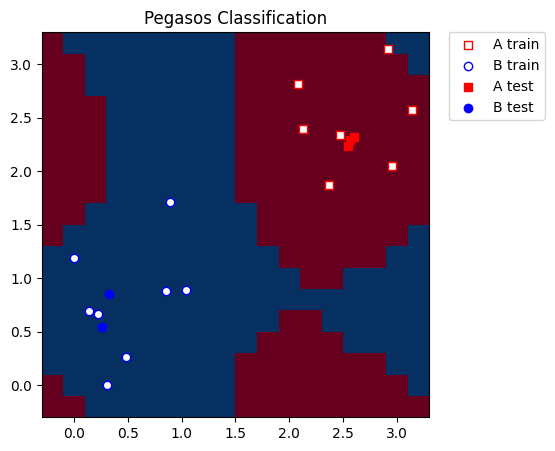

In [8]:
# Specify the plot settings
plt.figure(figsize=(5, 5))

# Color the mesh according to the binary classification
meshgrid_colors = meshgrid_colors.reshape(grid_x.shape)
plt.pcolormesh(grid_x, grid_y, meshgrid_colors, cmap="RdBu", shading="auto")

# Plot the train and test dataset using the function created earlier
plot_dataset(train_features, test_features, train_labels, test_labels)

# Visualize the result
plt.show()

## What was learned
We learned how to implement `PegasosQSVC` for binary classification problem using `FidelityQuantumKernel` on a `ZFeatureMap` quantum feature map, following classical machine learning procedure step by step.

In [9]:
import qiskit.tools.jupyter

%qiskit_version_table
%qiskit_copyright